# Counte mRNA inside Tracking Cells

In [2]:
using FileIO, Images
using ImageSegmentation
using Plots
using Random
using Distributions
using GaussianMixtures
using Statistics

┌ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1260
  likely near /home/hf/.julia/packages/Images/0SDGT/src/Images.jl:60
┌ Info: Precompiling ImageSegmentation [80713f31-8817-5129-9cf8-209ff8fb23e1]
└ @ Base loading.jl:1260
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260
┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1260
┌ Info: Precompiling GaussianMixtures [cc18c42c-b769-54ff-9e2a-b28141a64aae]
└ @ Base loading.jl:1260


In [3]:
function get_random_color(seed)
    Random.seed!(seed)
    rand(RGB{N0f8})
end

get_random_color (generic function with 1 method)

In [4]:
"""
Generate border form watershed result
"""
#function watershedborder(watershed_segments::SegmentedImage{Array{Int64,2},Float64} )
function watershedborder(watershed_segments)
    marker_border = BitArray(undef, size(watershed_segments.image_indexmap));
    marker_border .=false
    #marker_border = zeros(Int8, size(watershed_segments.image_indexmap));
    for label in watershed_segments.segment_labels
        marker_border .|= ((watershed_segments.image_indexmap.==label) .⊻ erode(watershed_segments.image_indexmap .==label));
    end
    marker_border;
end

watershedborder (generic function with 1 method)

In [5]:
data_dir = "/datahub/rawdata/tandeng/mRNA_imaging/mRNA_confocal_hamamatsu-60X-TIRF";
img_15_1 = load(File(format"TIFF", "$data_dir/20200315/HE7-11-1-80uw-const_1_s1.ome.btf.tiff"));

In [7]:
img_16_2 = load(File(format"TIFF", "$data_dir/20200316/HE7-11-1-80uw-PWM_1_s2.ome.tiff"));

## 1. Distance Tranform

In [689]:
function GaussianDistance(time::Int)
	imgout = zeros(N0f16, 1900, 1300, time)
    for t in 1:time
        imgx = img[:,:,20*t+14];
        imgx_th = imfilter(imgx, Kernel.gaussian(9)) .> (140/0xffff);
        imgx_dist = distance_transform(feature_transform(imgx_th));
        imgx_markers = label_components( imgx_dist .< 10 );
        imgx_segments = watershed( imgx_dist, imgx_markers );
        #imgx_segments = watershed( imgx_th, imgx_markers);
        imgout[:,:,t] = .~watershedborder(imgx_segments) .* imgx;
    end
    imgout;
end

GaussianDistance (generic function with 2 methods)

In [691]:
@time gaussian_distance = GaussianDistance(124);
save("test_1_14.tiff", gaussian_distance);

449.506440 seconds (152.00 k allocations: 51.523 GiB, 7.89% gc time)


# 2. Second method to find suitable marker

In [692]:
function dog(time::Int)
    imgout = zeros(N0f16, 1900, 1300, time)
    for t in 1:time
        imgx = img[:,:,20*t+14];
        imgx_th = imfilter(imgx, Kernel.gaussian(11)) .> (140/0xffff);
        imgx_dog = imfilter(imgx,Kernel.gaussian(9))-imfilter(imgx,Kernel.gaussian(120))
        #[ imgx.*100  imgx_dog.*1000  Gray.(imgx_th) Gray.(imgx_dog.>0.0002)]
        imgx_markers = label_components( imgx_dog.>0.0002);
        imgx_markers_sl = copy(imgx_markers);
        for i in 1:maximum(imgx_markers[:]) 
            if sum(imgx_markers .== i) < 1e4
                imgx_markers_sl = imgx_markers_sl .* (imgx_markers .!=[i])
                # remove selected seed
            end
        end
        imgx_segments = watershed( imfilter(1 .- imgx, Kernel.gaussian(9)), imgx_markers_sl);
        #[ Gray.(imgx_markers./maximum(imgx_markers[:])) ]
        #[ imgx.*100 Gray.(imgx_segments.image_indexmap./length(imgx_segments.segment_labels)) ]
        imgout[:,:,t] = .~watershedborder(imgx_segments) .* imgx;
    end
    imgout;
end

dog (generic function with 1 method)

In [ ]:
function nuclei_gmm(img, watershed_segments::SegmentedImage{Array{Int64,2},Float64})
    for label in watershed_segments
        edge, counte = imhist(imfilter(img, Kernel.gaussian(7)) .* (watershed_segments.image_indexmap.==label ));
    	#plot(edge[2:end], counte[3:end])
        gmm = GMM(3, [i for i in real(imfilter(imgx, Kernel.gaussian(7)) .* (imgx_segments.image_indexmap.==27)) if i>4e-5]);
        imgx .* ((imfilter(imgx, Kernel.gaussian(7)) .* (imgx_segments.image_indexmap.==27) ) .> gmm.μ[3]) .*100
    end
end

In [693]:
@time test2_14 = dog(124);
save("test2_14.tiff", test2_14);

720.305134 seconds (282.33 k allocations: 201.867 GiB, 17.52% gc time)


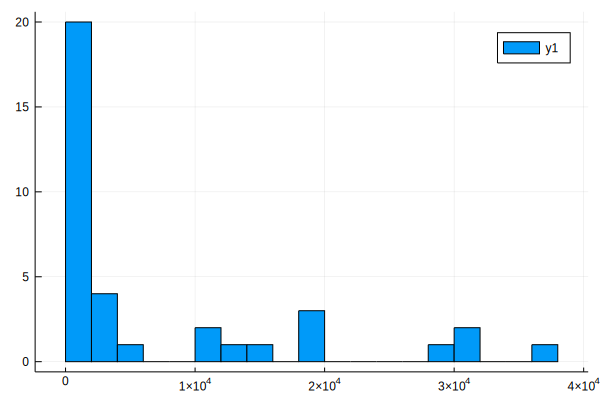

In [312]:
marker = [sum(imgx_markers .== i) for i in 1:maximum(imgx_markers) ];
histogram(marker, nbins=20)

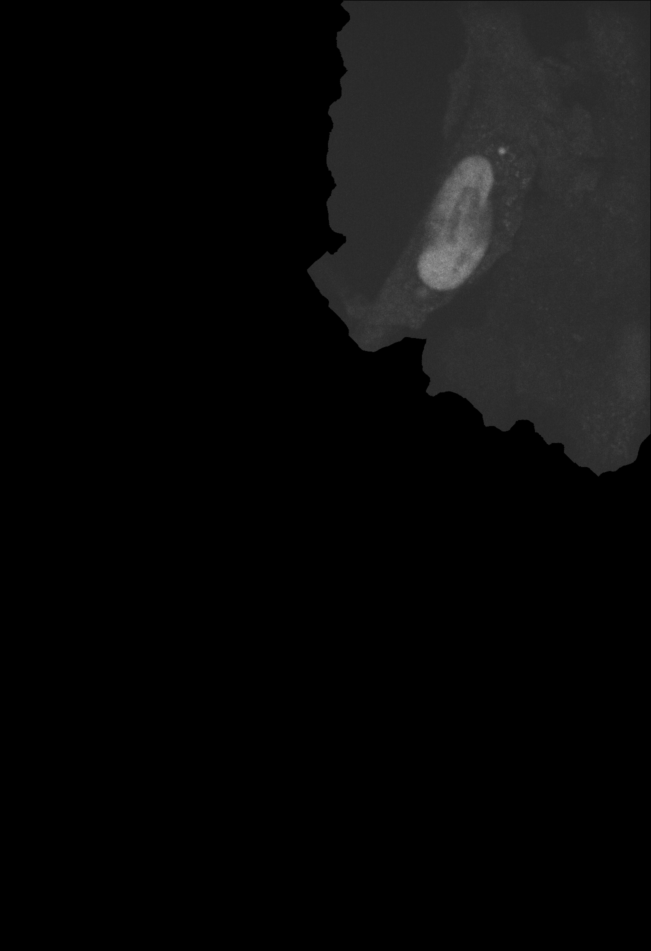

In [334]:
imgx .* (imgx_segments.image_indexmap.==27) .*100

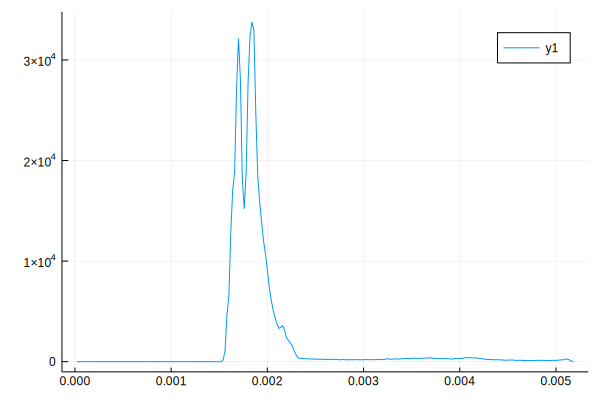

In [379]:
edge, counte = imhist(imfilter(imgx, Kernel.gaussian(7)) .* (imgx_segments.image_indexmap.==27) );
plot(edge[2:end], counte[3:end])

In [380]:
gmm = GMM(3, [i for i in real(imfilter(imgx, Kernel.gaussian(7)) .* (imgx_segments.image_indexmap.==27)) if i>4e-5]);

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.512950e-04
      1       9.403939e-05      -5.725561e-05 |        3
      2       9.128871e-05      -2.750684e-06 |        3
      3       9.039588e-05      -8.928299e-07 |        3
K-means converged with 3 iterations (objv = 9.03958751673867e-5)


┌ Info: Initializing GMM, 3 Gaussians diag covariance 1 dimensions using 516919 data points
└ @ GaussianMixtures /home/hf/.julia/packages/GaussianMixtures/3jRIL/src/train.jl:78
┌ Info: K-means with 3000 data points using 3 iterations
│ 500.0 data points per parameter
└ @ GaussianMixtures /home/hf/.julia/packages/GaussianMixtures/3jRIL/src/train.jl:139
┌ Warning: Variances had to be floored 
│   ind = [1, 2, 3]
└ @ GaussianMixtures /home/hf/.julia/packages/GaussianMixtures/3jRIL/src/train.jl:258
┌ Warning: Variances had to be floored 
│   ind = [1, 2, 3]
└ @ GaussianMixtures /home/hf/.julia/packages/GaussianMixtures/3jRIL/src/train.jl:258
┌ Warning: Variances had to be floored 
│   ind = [1, 2, 3]
└ @ GaussianMixtures /home/hf/.julia/packages/GaussianMixtures/3jRIL/src/train.jl:258
┌ Warning: Variances had to be floored 
│   ind = [1, 2, 3]
└ @ GaussianMixtures /home/hf/.julia/packages/GaussianMixtures/3jRIL/src/train.jl:258
┌ Warning: Variances had to be floored 
│   ind = [1, 2, 3]
└ 

In [381]:
[gmm.μ gmm.w]

3×2 Array{Float64,2}:
 0.00179465  0.736267
 0.00379739  0.0584128
 0.00200267  0.20532

In [382]:
gmm_mm = MixtureModel(gmm)

MixtureModel{Normal{Float64}}(K = 3)
components[1] (prior = 0.7363): Normal{Float64}(μ=0.001794645191997088, σ=9.387936253366946e-9)
components[2] (prior = 0.0584): Normal{Float64}(μ=0.003797385783700723, σ=3.2003100792516977e-7)
components[3] (prior = 0.2053): Normal{Float64}(μ=0.002002669744912961, σ=4.2954883850133567e-8)


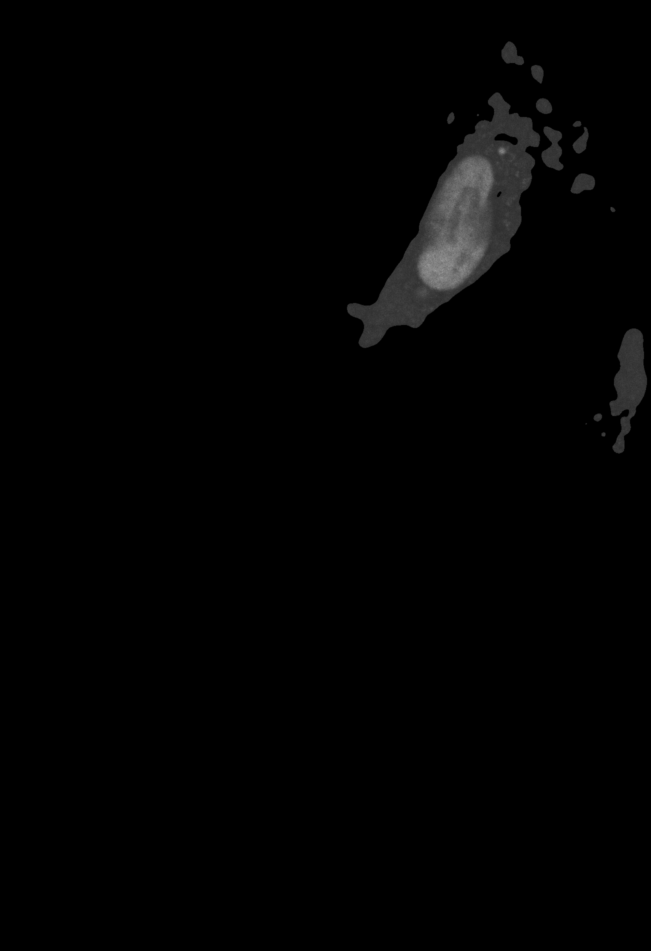

In [384]:
imgx .* ((imfilter(imgx, Kernel.gaussian(7)) .* (imgx_segments.image_indexmap.==27) ) .> gmm.μ[3]) .*100

# 3. LoG, Distance Map

In [112]:
"""
Use LoG and Distance Map fiter raw image to extract cell
"""
function LoGDistance(time)
    imgout = zeros(N0f16, 1900, 1300, time)
    for i in 1:time
        imgx = img[:, :, 20*i+14];
        imgx_log = imfilter(imgx, Kernel.LoG(40)) .< -1e-7 ;
        imgx_dist = distance_transform(feature_transform(imgx_log)) .^ 0.5;
        imgx_markers = label_components( imgx_dist .< 5);
        #imgx_segments = watershed( imgx_dist, imgx_markers);  
        #imgx_segments = watershed( imgx, imgx_markers);
        imgout[:,:,i] = .~watershedborder(imgx_segments).*imgx;
    end
	#map(i->get_random_color(i),labels_map(imgx_segments))]
    imgout
end

"""
Use LoG without Distance Map fiter raw image to extract cell
"""
function split_cell_LoG(stack::Array{Gray{Normed{UInt16,16}},3}, time::Int)
    img_edge = zeros(N0f16, 1900, 1300, time);
    img_clear = zeros(N0f16, 1900, 1300, time);
    for i in 1:time
        imgx = mapwindow(median!, stack[:, :, 20*i+14], (5,5));
        imgx_log = imfilter(imgx, Kernel.LoG(40)) .< -1e-7 ;
        imgx_dist = distance_transform(feature_transform(imgx_log)) .^ 0.5;
        imgx_markers = label_components( imgx_dist .< 5);
        #imgx_segments = watershed( imgx_dist, imgx_markers);  
        imgx_segments = watershed( imfilter(1 .- imgx, Kernel.gaussian(9)), imgx_markers);
        #imgout[:,:,i] = Gray.(imgx_segments.image_indexmap./maximum(imgx_segments.segment_labels));
        img_edge[:,:,i] = .~watershedborder(imgx_segments).*imgx;
        img_clear[:,:,i] = extract_nucleus( imgx, imgx_segments);
    end
	#map(i->get_random_color(i),labels_map(imgx_segments))]
    img_edge, img_clear;
end

split_cell_LoG

In [164]:
"""
Use LoG without Distance Map fiter raw image to extract cell
"""
function split_cell_LoG(stack::Array{Gray{Normed{UInt16,16}},3}, time::Int)
    img_edge = zeros(N0f16, 1900, 1300, time);
    img_clear = zeros(N0f16, 1900, 1300, time*20);
    for i in 1:time
        imgx = mapwindow(median!, stack[:, :, 20*i+14], (5,5));
        imgx_log = imfilter(imgx, Kernel.LoG(40)) .< -1e-7 ;
        imgx_dist = distance_transform(feature_transform(imgx_log)) .^ 0.5;
        imgx_markers = label_components( imgx_dist .< 5);
        #imgx_segments = watershed( imgx_dist, imgx_markers);  
        imgx_segments = watershed( imfilter(1 .- imgx, Kernel.gaussian(9)), imgx_markers);
        #imgout[:,:,i] = Gray.(imgx_segments.image_indexmap./maximum(imgx_segments.segment_labels));
        img_edge[:,:,i] = .~watershedborder(imgx_segments).*imgx;
        img_clear_mask = extract_nucleus( imgx, imgx_segments) .> 0;
        for z in 1:20
            img_clear[:,:,(i-1)*20+z] = img_clear_mask .* stack[:,:,(i-1)*20+z]
        end
    end
	#map(i->get_random_color(i),labels_map(imgx_segments))]
    img_edge, img_clear;
end

split_cell_LoG

In [164]:
"""
Use LoG without Distance Map fiter raw image to extract cell, 
"""
function split_cell_LoG(stack::Array{Gray{Normed{UInt16,16}},3}, time::Int)
    img_edge = zeros(N0f16, 1900, 1300, time);
    img_clear = zeros(N0f16, 1900, 1300, time*20);
    for i in 1:time
        imgx = mapwindow(median!, stack[:, :, 20*i+14], (5,5));
        imgx_log = imfilter(imgx, Kernel.LoG(40)) .< -1e-7 ;
        imgx_dist = distance_transform(feature_transform(imgx_log)) .^ 0.5;
        imgx_markers = label_components( imgx_dist .< 5);
        #imgx_segments = watershed( imgx_dist, imgx_markers);  
        imgx_segments = watershed( imfilter(1 .- imgx, Kernel.gaussian(9)), imgx_markers);
        #imgout[:,:,i] = Gray.(imgx_segments.image_indexmap./maximum(imgx_segments.segment_labels));
        img_edge[:,:,i] = .~watershedborder(imgx_segments).*imgx;
        img_clear_mask = extract_nucleus( imgx, imgx_segments) .> 0;
        for z in 1:20
            img_clear[:,:,(i-1)*20+z] = img_clear_mask .* stack[:,:,(i-1)*20+z]
        end
    end
	#map(i->get_random_color(i),labels_map(imgx_segments))]
    img_edge, img_clear;
end

split_cell_LoG

In [151]:
"""
Extract nucleus from sperated cell
"""
function extract_nucleus( img, watershed_segments::SegmentedImage{Array{Int64,2},Float64} )
    img_clear = zeros(N0f16, size(watershed_segments.image_indexmap));
    img_blur = imfilter(img, Kernel.gaussian(9));
    for label in watershed_segments.segment_labels
        cell = img_blur .* (watershed_segments.image_indexmap .== label);
        # only select 70% brigter region or fixed area
        gmm = GMM(3, [pixel for pixel in real(cell) if pixel > 1e-5]);
        nucleus_th = sort(gmm.μ, dims=1)[end-1];
        img_clear .+= ( remove_small_area(cell .> nucleus_th)) .*img;
    end
    img_clear;
end

"""
Just remove regions are small
"""
function remove_small_area(mask)
    mask_con = label_components(mask);
    mask_res = BitArray(undef, size(mask));
    mask_res .= false;cd
    for i in 1:maximum(mask_con)
        if sum(mask_con .== i) > 5e3
            mask_res .+= (mask_con.==i);
        end
    end
    mask_res;
end

extract_nucleus

In [ ]:
@time edge, clear = split_cell_LoG(img_15_1, 20);
save("output/img_15_1_edge.tiff", edge);
save("output/img_15_1_clear.tiff", clear);

In [ ]:
@time edge, clear = split_cell_LoG(img_16_2, 20);
save("output/img_16_2_edge_z.tiff", edge);
save("output/img_16_2_clear_z.tiff", clear);

In [ ]:
@time out = split_cell_LoG(img_16_2, 137);
save("output/img_16_2.tiff", out);

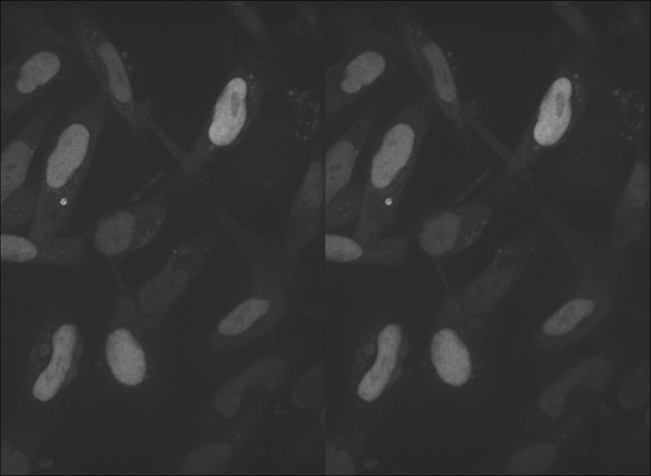

In [53]:
[img_15_1[:,:,10].*100 mapwindow(median!, img_15_1[:,:,10], (5,5)).*100]

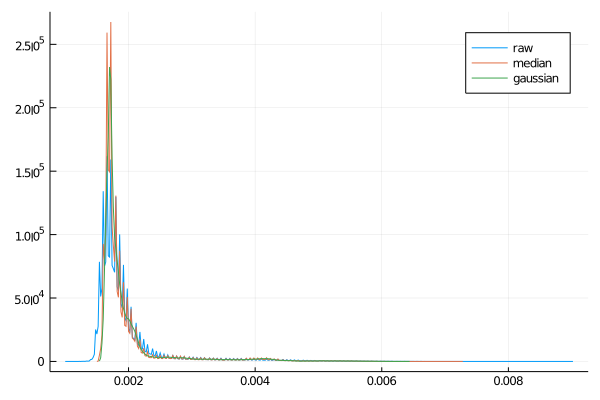

GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to un

In [75]:
edges, count = imhist(img_15_1[:,:,11]); 
edges2, count2 = imhist(mapwindow(median!, img_15_1[:,:,0], (5,5)));
edges3, count3 = imhist(imfilter(img_15_1[:,:,10], Kernel.gaussian(3)));
gr()
plot(edges, count[2:end], label="raw");
plot!(edges2, count2[2:end], label="median")
plot!(edges3, count3[2:end], label="gaussian")